1.Spline Fitting


(a). Polynominal fit


In order to fit the data while ensure the curve will go through the orgin, we need to add one constraint:
a1(0) + a2(0) + a3(0) + a4 = 0

In [96]:
# preparing data
raw = readcsv("xy_data.csv")
(m,n) = size(raw)

x = raw[:,1]
y = raw[:,2]

println()

In [97]:
# order of polynomial to use
k = 3

# fit using a function of the form f(x) = u1 x^k + u2 x^(k-1) + ... + uk x + u{k+1}
n = length(x)
A = zeros(n,k+1)
for i = 1:n
    for j = 1:k+1
        A[i,j] = x[i]^(k+1-j)
    end
end

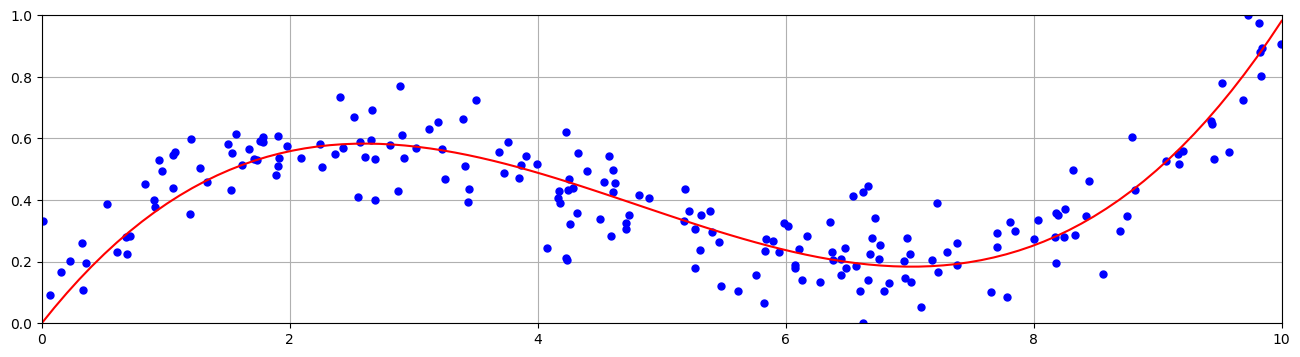

Academic license - for non-commercial use only
Optimal


In [98]:
using JuMP, Gurobi, PyPlot

m = Model(solver=GurobiSolver(OutputFlag=0))

@variable(m, u[1:k+1])
temp = [0;0;0;1]

@constraint(m, temp'*u == 0)
@objective(m, Min, sum( (y - A*u).^2 ) )

status = solve(m)
uopt = getvalue(u)
println(status)

npts = 100
xfine = linspace(0,10,npts)
ffine = ones(npts)
for j = 1:k
    ffine = [ffine.*xfine ones(npts)]
end
yfine = ffine * uopt
figure(figsize=(16,4))
plot( x, y, "b.", markersize=10)
plot( xfine, yfine, "r-")
axis([0,10,0,1])
grid()

(b). Spline fit


We need to use two models for this problem, one model for the part where x < 4, the other one for the part where x ≥ 4. We need to add two more constraints for the second model, the first one to ensure two plots have the same value at x = 4:


temp = [16;4;1]


@constraint(m2, temp’q == temp’popt)


The second constraint to make sure that two plots have the same slope at x = 4: 

temp_slope = [8;1;0]


@constraint(m2, temp_slope’q == temp_slope’popt)

In [99]:
# fitting a second order polynomial
k = 2

# solve two optimization, the first one fits the part of points where x < 4
n = length(x[1:76])
A1 = zeros(n,k+1)
for i = 1:n
    for j = 1:k+1
        A1[i,j] = x[i]^(k+1-j)
    end
end

using JuMP, Gurobi, PyPlot

# solving the first part
m1 = Model(solver=GurobiSolver(OutputFlag=0))

@variable(m1, p[1:k+1])
temp = [0;0;1]

@constraint(m1, temp'*p == 0)
@objective(m1, Min, sum( (y[1:76] - A1*p).^2 ) )
solve(m1)

popt = getvalue(p)

Academic license - for non-commercial use only


3-element Array{Float64,1}:
 -0.0930052
  0.479912 
 -0.0      

In [100]:
k = 2

# solve two optimization, the second one fits the part of points where x >= 4
n = length(x[77:200])
A2 = zeros(n,k+1)
x1 = x[76:200]
for i = 1:n
    for j = 1:k+1
        A2[i,j] = x1[i]^(k+1-j)
    end
end

# solving the second part
m2 = Model(solver=GurobiSolver(OutputFlag=0))

@variable(m2, q[1:k+1])
temp = [16;4;1]
temp_slope = [8;1;0]

# make sure they match at x = 4
@constraint(m2, temp'*q == temp'*popt)
# make sure it's smooth at x = 4
@constraint(m2, temp_slope'*q == temp_slope'*popt)
y1 = y[77:200]
@objective(m2, Min, sum( (y1 - A2*q).^2 ) )
solve(m2)

qopt = getvalue(q)

Academic license - for non-commercial use only


3-element Array{Float64,1}:
  0.0583636
 -0.731038 
  2.4219   

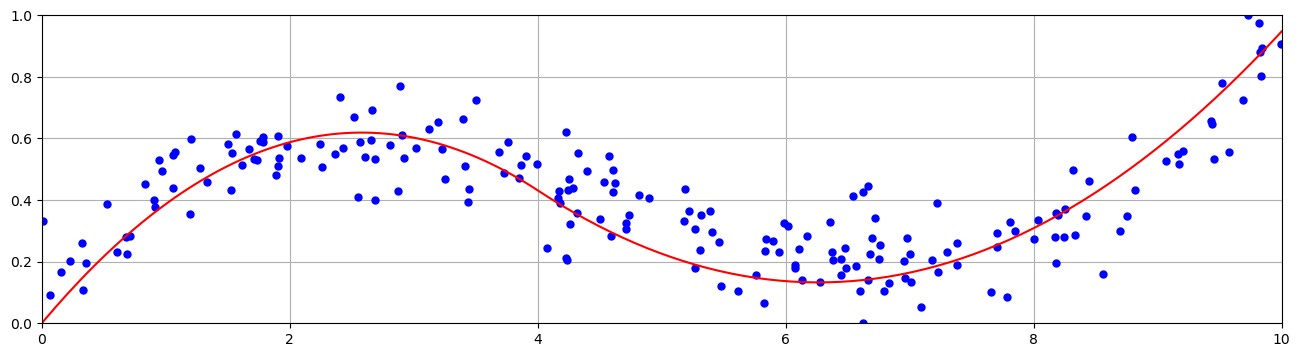

In [101]:
npts = length(x[1:76])
mpts = length(x[77:200])

xfine1 = linspace(0,4,npts)
ffine1 = ones(npts)
for j = 1:k
    ffine1 = [ffine1.*xfine1 ones(npts)]
end

xfine2 = linspace(4,10,mpts)
ffine2 = ones(mpts)
for j = 1:k
    ffine2 = [ffine2.*xfine2 ones(mpts)]
end

yfine1 = ffine1 * popt
yfine2 = ffine2 * qopt

xfine = vcat(xfine1, xfine2)
yfine = vcat(yfine1, yfine2)
figure(figsize=(16,4))
plot( x, y, "b.", markersize=10)
plot( xfine, yfine, "r-")
axis([0,10,0,1])
grid()

2.Moving Average


(a).

First for the moving average (MA) model:

In [102]:
# Load the data file
raw = readcsv("uy_data.csv");
u = raw[:,1];
y = raw[:,2];
T = length(u)

100

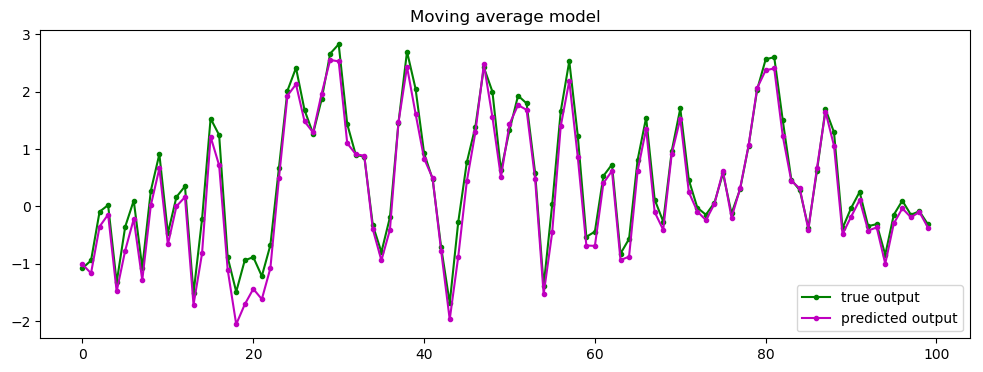

2.460854388269911

In [103]:
using PyPlot

# the window width is 5
width = 5
A = zeros(T,width)
for i = 1:width
    A[i:end,i] = u[1:end-i+1]
end
wopt = A\y
yest = A*wopt

figure(figsize=(12,4))
plot(y,"g.-",yest,"m.-")
legend(["true output", "predicted output"], loc="lower right");
title("Moving average model");
println()
MA_norm = norm(yest-y)

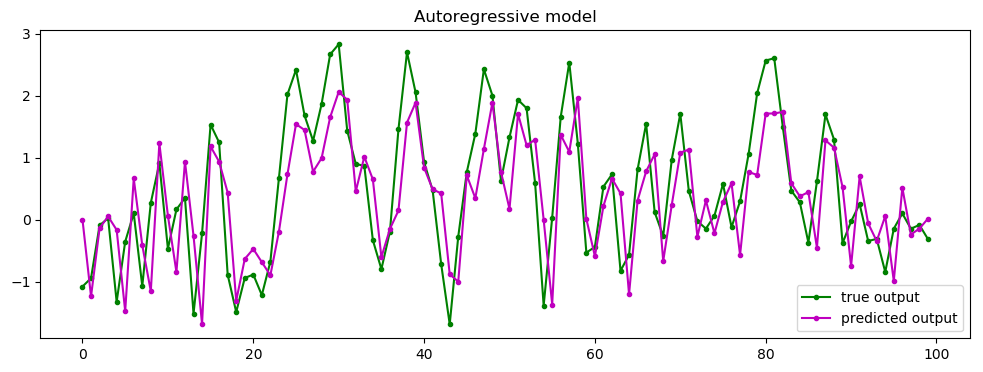

7.436691765656794

In [104]:
using PyPlot

# the window width is 5
width = 5
A = zeros(T,width)
y_temp = vcat(0, y)
y_temp = y_temp[1:end-1]

for i = 1:width
    A[i:end,i] = y_temp[1:end-i+1]
end
wopt = A\y
yest = A*wopt

figure(figsize=(12,4))
plot(y,"g.-",yest,"m.-")
legend(["true output", "predicted output"], loc="lower right");
title("Autoregressive model");
println()

AM_norm = norm(yest-y)

The difference in between those two estimates are:

In [105]:
difference = AM_norm - MA_norm
println(difference)

4.975837377386883


(b). Autoregressive moving average (ARMA) model


When k = l = 1, when the output is the linear combination of the current input and the past output

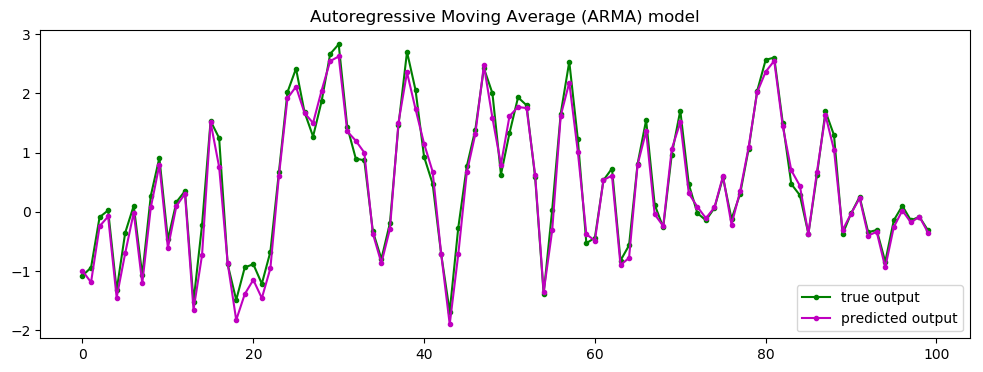

In [106]:
A = zeros(T, 2)

y_temp = vcat(0, y)
y_temp = y_temp[1:end-1]

A[1:end,1] = y_temp[1:end]
A[1:end,2] = u[1:end]

wopt = A\y
yest = A*wopt

figure(figsize=(12,4))
plot(y,"g.-",yest,"m.-")
legend(["true output", "predicted output"], loc="lower right");
title("Autoregressive Moving Average (ARMA) model");
println()

The error is:

In [107]:
err = norm(yest-y)
println(err)

1.8565828148734607


3.Hovercraft rendezvous


(a).


We let Alice's initial location to be at the origin, [0,0].

In [108]:
using JuMP, Gurobi, Mosek

# number of waypoints
k = 2
# vector of timepoints
T = zeros(Int, k)
# vector of waypoint locations
xw = zeros(2, k)

T[1] = 1
T[2] = 60

m = Model(solver = MosekSolver(LOG=0))

# Alice's location
@variable(m, xA[1:2,1:T[k]])
# Alice's velocity
@variable(m, vA[1:2,1:T[k]])
# Alice's thruster inputs
@variable(m, uA[1:2,1:T[k]])

# Bob's location
@variable(m, xB[1:2,1:T[k]])
# Bob's velocity
@variable(m, vB[1:2,1:T[k]])
# Bob's thruster inputs
@variable(m, uB[1:2,1:T[k]])

# Alice is going north at 20 mph at T = 1
@constraint(m, vA[:,1] .== [0;20])

# Let Alice's initial location to be at [0,0]
@constraint(m, xA[:,1] .== [0;0])

# Bob is located half a mile east of Alice
@constraint(m, xB[:,1] .== xA[:,1] .+ [0.5;0])

# Bob is initially moving east at 30mph
@constraint(m, vB[:,1] .== [30;0])

# Alice and Bob rendezvous at T = 60
@constraint(m, xA[:,60] .== xB[:,60])

for t in 1:T[k]-1
        @constraint(m, xA[:,t+1] .== xA[:,t] + 1/3600*vA[:,t])
        @constraint(m, vA[:,t+1] .== vA[:,t] + uA[:,t])
end

for t in 1:T[k]-1
        @constraint(m, xB[:,t+1] .== xB[:,t] + 1/3600*vB[:,t])
        @constraint(m, vB[:,t+1] .== vB[:,t] + uB[:,t])
end

@objective(m, Min, sum(uA.^2)+sum(uB.^2))

status = solve(m)

# locations of Alice and Bob
Ax = getvalue(xA)
Bx = getvalue(xB)

# total energy use
energy = getobjectivevalue(m)

105.93070479100969

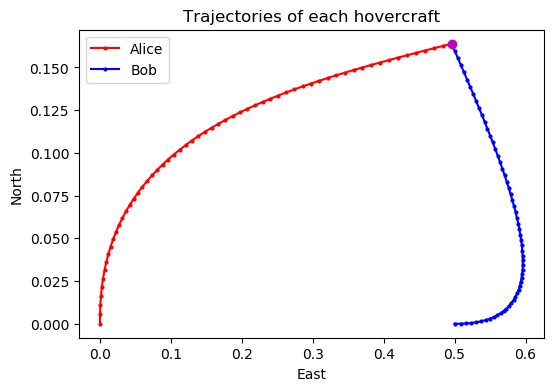

PyObject <matplotlib.legend.Legend object at 0x139c94190>

In [109]:
using PyPlot

figure(figsize=(6,4))
plot( Ax[1,:], Ax[2,:], "r.-", markersize=4 )
plot( Bx[1,:], Bx[2,:], "b.-", markersize=4 )
plot( Ax[1,60], Ax[2,60], "m.", markersize=12)
xlabel("East")
ylabel("North")
title("Trajectories of each hovercraft")
legend(["Alice", "Bob"])

In [110]:
println("Rendezvous point: ", Ax[:,60])
println("Total energy used: ", energy)

Rendezvous point: [0.495833, 0.163889]
Total energy used: 105.93070479100969


Therefore, Alice and Bob's hovercrafts should follow the trajectories shown above. Their rendezvous point is [0.495833, 0.163889], and the total energy used is 105.93070479100969

(b).


We let Alice's initial location to be at origin, [0,0].

In [111]:
using JuMP, Gurobi, Mosek

# number of waypoints
k = 2
# vector of timepoints
T = zeros(Int, k)
# vector of waypoint locations
xw = zeros(2, k)

T[1] = 1
T[2] = 60

m = Model(solver = MosekSolver(LOG=0))

# Alice's location
@variable(m, xA[1:2,1:T[k]])
# Alice's velocity
@variable(m, vA[1:2,1:T[k]])
# Alice's thruster inputs
@variable(m, uA[1:2,1:T[k]])

# Bob's location
@variable(m, xB[1:2,1:T[k]])
# Bob's velocity
@variable(m, vB[1:2,1:T[k]])
# Bob's thruster inputs
@variable(m, uB[1:2,1:T[k]])

# Alice is going north at 20 mph at T = 1
@constraint(m, vA[:,1] .== [0;20])

# Let Alice's initial location to be at [0,0]
@constraint(m, xA[:,1] .== [0;0])

# Bob is located half a mile east of Alice
@constraint(m, xB[:,1] .== xA[:,1] .+ [0.5;0])

# Bob is initially moving east at 30mph
@constraint(m, vB[:,1] .== [30;0])

# Alice and Bob rendezvous at T = 60
@constraint(m, xA[:,60] .== xB[:,60])

# Velocity match at T = 60
@constraint(m, vA[:,60] .== vB[:,60])

for t in 1:T[k]-1
        @constraint(m, xA[:,t+1] .== xA[:,t] + 1/3600*vA[:,t])
        @constraint(m, vA[:,t+1] .== vA[:,t] + uA[:,t])
end

for t in 1:T[k]-1
        @constraint(m, xB[:,t+1] .== xB[:,t] + 1/3600*vB[:,t])
        @constraint(m, vB[:,t+1] .== vB[:,t] + uB[:,t])
end

@objective(m, Min, sum(uA.^2)+sum(uB.^2))

status = solve(m)

# locations of Alice and Bob
Ax = getvalue(xA)
Bx = getvalue(xB)

# velocities of Alice and Bob
Av = getvalue(vA)
Bv = getvalue(vB)

# total energy use
energy = getobjectivevalue(m)

234.5704266359006

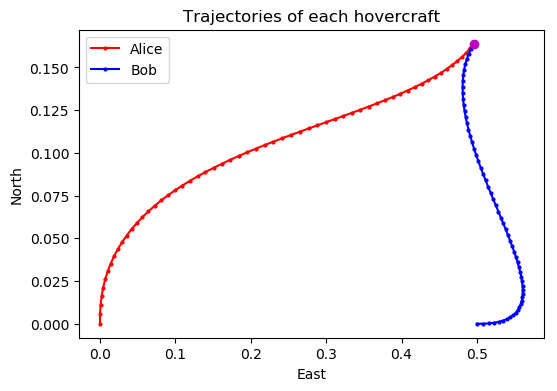

PyObject <matplotlib.legend.Legend object at 0x139d0fbd0>

In [112]:
using PyPlot

figure(figsize=(6,4))
plot( Ax[1,:], Ax[2,:], "r.-", markersize=4 )
plot( Bx[1,:], Bx[2,:], "b.-", markersize=4 )
plot( Ax[1,60], Ax[2,60], "m.", markersize=12)
xlabel("East")
ylabel("North")
title("Trajectories of each hovercraft")
legend(["Alice", "Bob"])

In [113]:
println("Rendezvous point: ", Ax[:,60])
println("Speed when rendezvous: ", Av[:,60])
println("Total energy used: ", energy)

Rendezvous point: [0.495833, 0.163889]
Speed when rendezvous: [15.0, 10.0]
Total energy used: 234.5704266359006


The rendezvous location is [0.495833, 0.163889], which is the same from the one obtained in the previous question. The speed when rendezvous is [15.0, 10.0], and the total energy used is 234.5704266359006.